# Setup

## Imports

In [1]:
import os.path

from glob import glob
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix

In [2]:
from vaiutils import path_consts, smooth_plot, plot_images
from vaidata import pickle_load, pickle_dump

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [4]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

## Define Useful Variables and Functions

In [5]:
for k, v in path_consts('NameLang', 'NameLang'):
    exec(k + '=v')

In [6]:
def get_name(name_idx):
    if type(name_idx[0]) is list:
        return [get_name(n) for n in name_idx]

    return ''.join([idx_char[i] for i in name_idx])

In [7]:
def save_model():
    torch.save(model.state_dict(), os.path.join(DIR_CHECKPOINTS, 'model.dat'))
    pickle_dump(os.path.join(DIR_CHECKPOINTS, 'history.p'), history)

In [8]:
def load_model():
    global history
    if not os.path.exists(os.path.join(DIR_CHECKPOINTS, 'model.dat')):
        return
    model.load_state_dict(torch.load(os.path.join(DIR_CHECKPOINTS, 'model.dat')))
    history = pickle_load(os.path.join(DIR_CHECKPOINTS, 'history.p'))

## Load Data

In [9]:
languages = []
names = []
for filename in glob(os.path.join(DIR_DATA, '*.txt')):
    languages.append(os.path.split(filename)[1][:-4])
    with open(filename) as f:
        names.append(f.readlines())

    for i in range(len(names[-1])):
        names[-1][i] = names[-1][i].split()[0]


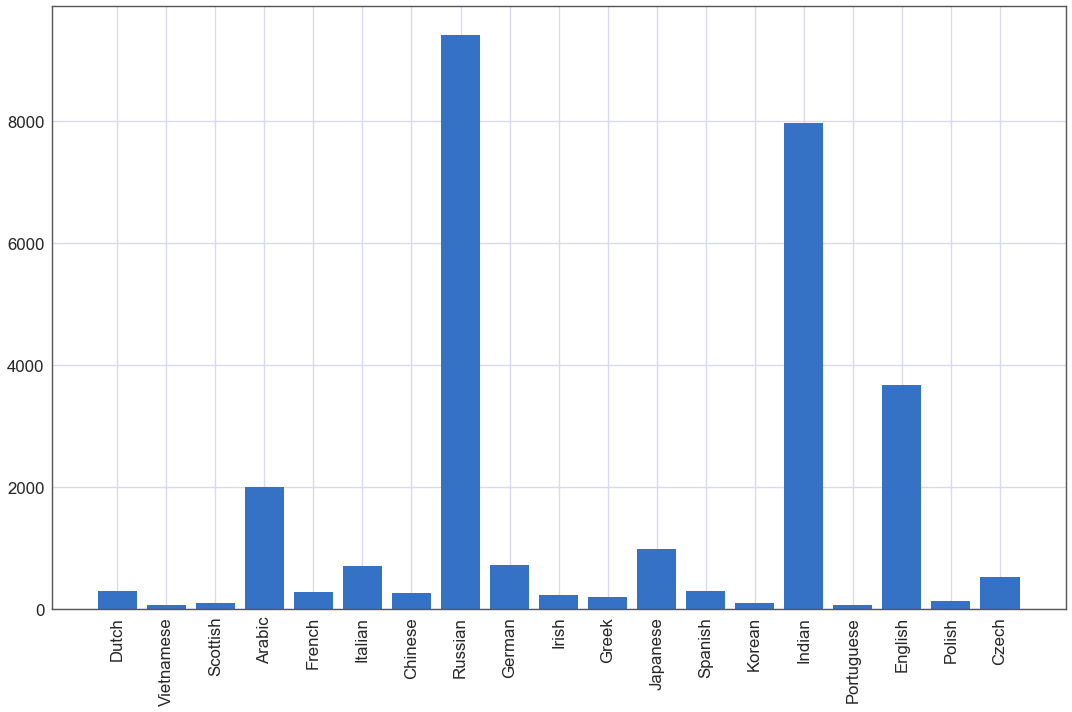

In [10]:
name_lengths = np.array([len(name) for name in names])
plt.bar(np.arange(len(languages)), name_lengths)
plt.xticks(np.arange(len(languages)), languages, rotation='vertical')
plt.show()

In [11]:
for i in [3, 7, 14, 16]:
    names[i] = list(np.array(names[i])[randint(0, len(names[i]), 1000)])

In [12]:
name_freq = 1 / name_lengths
name_freq = name_freq / name_freq.sum()

In [13]:
all_names = ''

for name, language in zip(names, languages):
    all_names += ' '.join(name)
    print(language, np.array(name)[randint(0, len(name), 5)])

Dutch ['Roggeveen' 'Hautem' 'Maas' 'Schoonenburg' 'Romeijnders']
Vietnamese ['Thuy' 'Doan' 'Vo' 'Lam' 'An']
Scottish ['Boyle' 'Grant' 'Cameron' 'Crawford' 'Jamieson']
Arabic ['Kassis' 'Naifeh' 'Maalouf' 'Deeb' 'Hadad']
French ['Hébert' 'Charbonneau' 'Paul' 'Salvage' 'Gage']
Italian ['Pagano' 'Di' 'Pesce' 'Capello' 'Amadori']
Chinese ['Chi' 'Fei' 'Kwei' 'Hui' 'Gai']
Russian ['Agrest' 'Piruev' 'Lohmatikov' 'Vaindrah' 'Kachalovsky']
German ['Vogel' 'Hausler' 'Werner' 'Böttcher' 'Dittmar']
Irish ["O'Toole" 'Eoghan' 'Cuidightheach' 'Nuallan' 'Maciomhair']
Greek ['Fotopoulos' 'Kaglantge' 'Dritsas' 'Missiakos' 'Katsourinis']
Japanese ['Shimura' 'Seo' 'Terajima' 'Omura' 'Sada']
Spanish ['Gonzales' 'Ibarra' 'Etxebarria' 'Montero' 'Vivas']
Korean ['Ryom' 'Son' 'Lim' 'So' 'Hong']
Indian ['Aabid' 'Panwar' 'Yatin' 'Sushmita' 'Idrish']
Portuguese ['Magalhães' 'Albuquerque' 'Maria' 'Soares' 'Palmeiro']
English ['Deverell' 'Elmes' 'Pillay' 'Milner' 'Roebuck']
Polish ['Zawisza' 'Róg' 'Serafin' 'Wojewód

In [14]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(all_names)

In [15]:
char_idx = tokenizer.word_index
idx_char = {v: k for k, v in char_idx.items()}

In [16]:
vocab_size = len(char_idx)

In [17]:
names = [tokenizer.texts_to_sequences(name) for name in names]
names = [[np.array(n) for n in name] for name in names]

In [18]:
data = []
for i, name in enumerate(names):
    data += [(n, i) for n in name]

In [19]:
FRAC_TEST = 0.2

In [20]:
test_idx = sorted(randint(0, len(data), int(FRAC_TEST * len(data))))
train_idx = sorted(np.array(list(set(list(range(len(data)))) - set(test_idx))))

In [21]:
data_test = np.array(data)[test_idx]
data = np.array(data)[train_idx]

In [22]:
if os.path.exists(os.path.join(DIR_CHECKPOINTS, 'tokenizer.p')):
    tokenizer = pickle_load(os.path.join(DIR_CHECKPOINTS, 'tokenizer.p'))
    data = pickle_load(os.path.join(DIR_CHECKPOINTS, 'data.p'))
    data_test = pickle_load(os.path.join(DIR_CHECKPOINTS, 'data_test.p'))
else:
    pickle_dump(os.path.join(DIR_CHECKPOINTS, 'tokenizer.p'), tokenizer)
    pickle_dump(os.path.join(DIR_CHECKPOINTS, 'data.p'), data)
    pickle_dump(os.path.join(DIR_CHECKPOINTS, 'data_test.p'), data_test)

# Create Network

In [23]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, initial_hidden=None, return_sequences=False):
        super().__init__()
        if initial_hidden is None:
            self.initial_hidden = Variable(torch.zeros(hidden_size)).cuda()
        else:
            self.initial_hidden = Variable(initial_hidden).cuda()

        self.ih = nn.Linear(input_size, hidden_size)
        self.hh = nn.Linear(hidden_size, hidden_size)
        self.return_sequences = return_sequences

    def forward(self, x):
        if not self.return_sequences:
            h = self.initial_hidden
            for x_t in x:
                h = F.tanh(self.ih(x_t) + self.hh(h))
            return torch.unsqueeze(h, 0)

        h_t = [self.initial_hidden]
        for x_t in x:
            h_t.append(F.tanh(self.ih(x_t) + self.hh(h_t[-1])))
        return torch.stack(h_t[1:])

In [24]:
class LangFinder(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(torch.unsqueeze(x, 0))
        x = self.rnn(x)[1].squeeze(0)
        return self.fc(x)

# Train Model

In [25]:
model = LangFinder(32, 128, len(languages)).cuda()

In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [27]:
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(name_freq).cuda())

In [28]:
def get_loss(data):
    total_loss = 0
    total_correct = 0
    for name, language in data:
        y_true = Variable(torch.LongTensor(np.array([language]))).cuda()
        y_pred = model(Variable(torch.LongTensor(name)).cuda())
        loss = criterion(y_pred, y_true)
        
        total_loss += loss.data.cpu().numpy()[0]
        total_correct += int(y_pred.max(0)[1].data.cpu().numpy()[0] == language)
        
    return total_loss / len(data), total_correct / len(data)

In [29]:
history = {'loss': [], 'acc': [], 'test_loss':[], 'test_acc': []}
batches_per_epoch = len(data)

def optimize(epochs=1, writes_per_epoch=10):
    running_history = {'loss': [], 'acc': []}
    
    load_model()
    for epoch in tqdm_notebook(range(epochs)):
        prog_bar = tqdm_notebook(data[np.random.permutation(len(data))])
        for batch, (name, language) in enumerate(prog_bar):
            y_true = Variable(torch.LongTensor(np.array([language]))).cuda()
            y_pred = model(Variable(torch.LongTensor(name)).cuda())
            loss = criterion(y_pred, y_true)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_history['loss'].append(loss.data.cpu().numpy()[0])
            running_history['acc'].append(int(y_pred.max(0)[1].data.cpu().numpy()[0] == language))
            if batch % int(batches_per_epoch / (writes_per_epoch - 1)) == 0:
                for k in history.keys():
                    if k not in running_history.keys():
                        continue
                    history[k].append(mean(running_history[k]))
                    running_history[k] = []
                    prog_bar.set_description('{:.2f}'.format(history['loss'][-1]))
                    
        test_loss, test_acc = get_loss(data_test)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        if argmin(history['test_loss']) == len(history['test_loss']) - 1:
            save_model()

In [30]:
optimize(50)

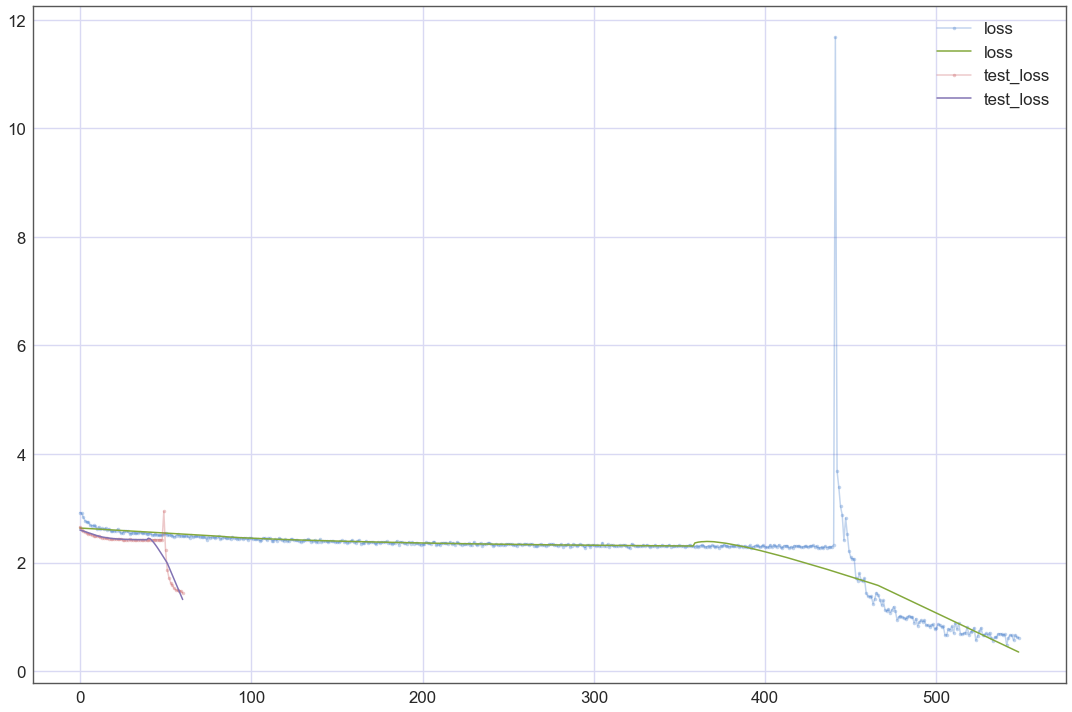

In [40]:
smooth_plot(history, keys=['loss', 'test_loss'], remove_outlier=False)

In [ ]:
smooth_plot(history, keys=['acc', 'test_acc'], remove_outlier=True)

## Test Model

In [39]:
load_model()

In [43]:
for _ in range(10):
    sample_name, real_class = data_test[randint(len(data_test))]
    sample_class = model(Variable(torch.LongTensor(sample_name).cuda()))

    print("{} ({}) {}-{}%".format(get_name(sample_name), languages[real_class],
                                  languages[sample_class.max(
                                      1)[1].data.cpu().numpy()[0]],
                                  int(F.softmax(sample_class).max(1)[0].data.cpu().numpy()[0] * 100)))

Jandale (Dutch) Indian-23%
Mvsenev (Russian) Russian-99%
Bukoski (Polish) Japanese-60%
Aanbai (Indian) Indian-67%
zeinrigh (German) German-87%
Auracughi (Japanese) Japanese-94%
Sabbac (Arabic) Arabic-89%
Teacue (Irish) French-55%
Nonn (Irish) Irish-40%
AaalouP (Arabic) Arabic-99%


In [45]:
def plot_confusion_matrix(data):
    y_true = np.array([d[1] for d in data])
    y_pred = np.array([model(Variable(torch.LongTensor(d[0]).cuda(), volatile=True)).data.cpu().numpy()[0].argmax() for d in tqdm_notebook(data)])
    
    sample_weight = np.array([name_freq[y] for y in y_true])
    
    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)

    plot_images([cm], cmap='gray', flags='retain', pixel_range='auto')
    plt.xticks(np.arange(len(languages)), languages, rotation='vertical')
    plt.yticks(np.arange(len(languages)), languages, rotation='horizontal')
    plt.grid(False)
    plt.show()

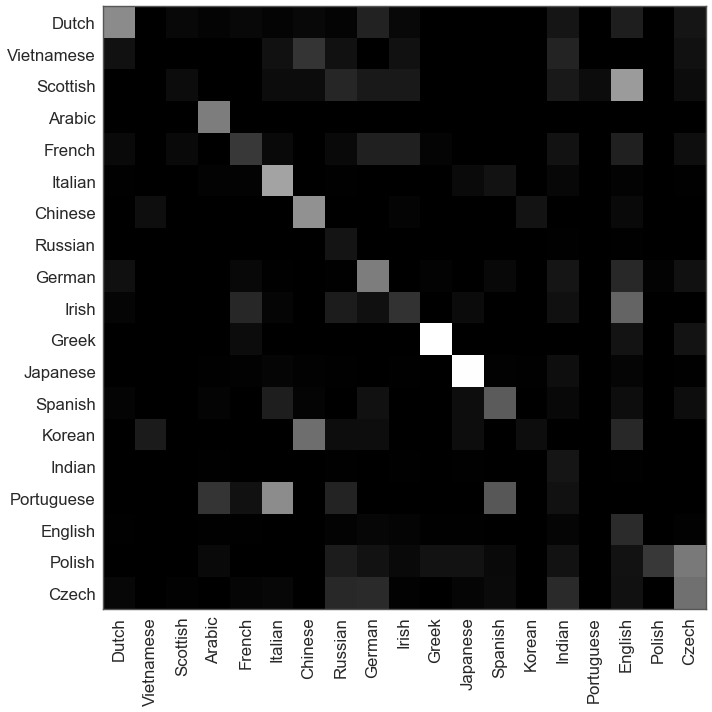

In [46]:
plot_confusion_matrix(data_test)

In [47]:
def predict(name):
    name_array = tokenizer.texts_to_sequences(name)
    name_array = np.array([n[0] for n in name_array])
    return languages[model(Variable(torch.LongTensor(name_array).cuda(), volatile=True)).data.cpu().numpy()[0].argmax()]

In [48]:
for name in ['Schmidhuber', 'Hinton', 'Bengio', 'Srivastava', 'Vaisakh']:
    print(name, '-', predict(name))

Schmidhuber - Czech
Hinton - English
Bengio - Italian
Srivastava - Indian
Vaisakh - Russian
